In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation


!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


! pip install folium==0.5.0
import folium # plotting library

import matplotlib.pyplot as plt

print('Folium installed')
print('Libraries imported.')

     |████████████████████████████████| 79 kB 8.5 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=d56e8fe44a0445532a6acc5752c16587694eca544ab276a8dd4d5a012ad9fea0
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium
Folium installed
Libraries imported.


In [2]:
CLIENT_ID = 'VTCFGDWGL3HENURPZ3FTCJCJQSV4XIPVC5B4EFXCVMPGX5OI' # your Foursquare ID
     
CLIENT_SECRET = 'YXSVGIAT2R04AVLO3B1CAN2K5ZTOVKU4GIUKNRUYYESUHXSG' # your Foursquare Secret
ACCESS_TOKEN = 'MHRHM0F5EBKHKDRPEYBCYNQNCFUTEA0XMJKNDSMXZULVNET4' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRETT:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VTCFGDWGL3HENURPZ3FTCJCJQSV4XIPVC5B4EFXCVMPGX5OI
CLIENT_SECRETT:YXSVGIAT2R04AVLO3B1CAN2K5ZTOVKU4GIUKNRUYYESUHXSG


In [3]:
def fetchGeoCoordinates(address):
    print(address)
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print(latitude, longitude)
    return latitude,longitude
    


In [4]:
 # keep only columns that include venue name, and anything that is associated with location
def process_dataFrame(dataframe):
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']
        
        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']

    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

    return dataframe_filtered

In [5]:
def fetchRestaurants(latitude,longitude):
    search_query = 'Indian'
    radius = 5000
    print(search_query + ' .... OK!')
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
    print(url)
    results = requests.get(url).json()
   
    
    # assign relevant part of JSON to venues
    venues = results['response']['venues']

    # tranform venues into a dataframe
    dataframe = json_normalize(venues)
    dataframe_filtered=process_dataFrame(dataframe)
    Indian_rest_df=dataframe_filtered[(dataframe_filtered.categories=='Indian Restaurant')]
    return Indian_rest_df
   
    
   

In [6]:
#Gets various venues(places of interest) around provided latitude longitudes
def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [7]:
# Gets venue details based on the venue ID
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [8]:
# create map of place using latitude and longitude values
def draw_folium(latitude,longitude,zoom,place_data):
    venues_map = folium.Map(location=[latitude, longitude], zoom_start=13)
    
    # add a red circle marker to represent the users address
    folium.CircleMarker(
        [latitude, longitude],
        radius=10,
        color='red',
        popup='Conrad Hotel',
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.6
    ).add_to(venues_map)
    
    # add the Indian restaurants as blue circle markers
    #for lat, lng, label in zip(res_dataframe.lat, res_dataframe.lng, res_dataframe.categories):
    #for lat, lng, label in zip(place_data.Latitude, place_data.Longitude, place_data.categories):
    for lat, lng, label in zip(place_data.Latitude, place_data.Longitude, place_data.Name):
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            color='blue',
            popup=label,
            fill = True,
            fill_color='blue',
            fill_opacity=0.6
        ).add_to(venues_map)

    return venues_map
    


In [9]:
userAddress='165,Broadway,NY-1006'
latitude,longitude=fetchGeoCoordinates(userAddress)
latitude,longitude
search_query = 'Indian'
radius = 5000
print(search_query + ' .... OK!')

165,Broadway,NY-1006
40.6769386 -73.4170694845788
Indian .... OK!


In [10]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=VTCFGDWGL3HENURPZ3FTCJCJQSV4XIPVC5B4EFXCVMPGX5OI&client_secret=YXSVGIAT2R04AVLO3B1CAN2K5ZTOVKU4GIUKNRUYYESUHXSG&ll=40.6769386,-73.4170694845788&oauth_token=MHRHM0F5EBKHKDRPEYBCYNQNCFUTEA0XMJKNDSMXZULVNET4&v=20180604&query=Indian&radius=5000&limit=30'

In [11]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ff13f779d461e6e742a8ce7'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '4e134a50fa769d21e9fd6a56',
    'name': 'Indian Island Beach',
    'location': {'address': 'The Bay',
     'lat': 40.66231733105059,
     'lng': -73.37410760679711,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.66231733105059,
       'lng': -73.37410760679711}],
     'distance': 3975,
     'cc': 'US',
     'city': 'Lindenhurst',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['The Bay', 'Lindenhurst, NY']},
    'categories': [{'id': '4bf58dd8d48988d1e2941735',
      'name': 'Beach',
      'pluralName': 'Beaches',
      'shortName': 'Beach',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/beach_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1609645943',
    'hasPerk': False},
   {'id': '4e4cf8d7bd413c4cc66da73

In [12]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.city,location.state,location.country,location.formattedAddress,location.postalCode
0,4e134a50fa769d21e9fd6a56,Indian Island Beach,"[{'id': '4bf58dd8d48988d1e2941735', 'name': 'B...",v-1609645943,False,The Bay,40.662317,-73.374108,"[{'label': 'display', 'lat': 40.66231733105059...",3975,US,Lindenhurst,NY,United States,"[The Bay, Lindenhurst, NY]",NaN
1,4e4cf8d7bd413c4cc66da730,Indian Taj,"[{'id': '4bf58dd8d48988d10f941735', 'name': 'I...",v-1609645943,False,127 Montauk Hwy,40.679276,-73.360977,"[{'label': 'display', 'lat': 40.67927551269531...",4742,US,Lindenhurst,NY,United States,"[127 Montauk Hwy, Lindenhurst, NY 11757]",11757
2,5f2ac5f281231e5ecdd9ceae,Massapequa Indian Fort,"[{'id': '4bf58dd8d48988d12d941735', 'name': 'M...",v-1609645943,False,NaN,40.653167,-73.461066,"[{'label': 'display', 'lat': 40.653167, 'lng':...",4561,US,Massapequa,NY,United States,"[Massapequa, NY 11758]",11758
3,4d16b0a98312236ae01659ba,457 N Indiana Ave,[],v-1609645943,False,NaN,40.693415,-73.382639,"[{'label': 'display', 'lat': 40.693415, 'lng':...",3436,US,Lindenhurst,NY,United States,"[Lindenhurst, NY 11757]",11757
4,501eccffe4b062004bf43af6,N. Indiana Ave,"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",v-1609645943,False,NaN,40.696690,-73.367317,"[{'label': 'display', 'lat': 40.69668960571289...",4740,US,Lindenhurst,NY,United States,"[Lindenhurst, NY 11757]",11757


In [13]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,postalCode,id
0,Indian Island Beach,Beach,The Bay,40.662317,-73.374108,"[{'label': 'display', 'lat': 40.66231733105059...",3975,US,Lindenhurst,NY,United States,"[The Bay, Lindenhurst, NY]",NaN,4e134a50fa769d21e9fd6a56
1,Indian Taj,Indian Restaurant,127 Montauk Hwy,40.679276,-73.360977,"[{'label': 'display', 'lat': 40.67927551269531...",4742,US,Lindenhurst,NY,United States,"[127 Montauk Hwy, Lindenhurst, NY 11757]",11757,4e4cf8d7bd413c4cc66da730
2,Massapequa Indian Fort,Monument / Landmark,NaN,40.653167,-73.461066,"[{'label': 'display', 'lat': 40.653167, 'lng':...",4561,US,Massapequa,NY,United States,"[Massapequa, NY 11758]",11758,5f2ac5f281231e5ecdd9ceae
3,457 N Indiana Ave,None,NaN,40.693415,-73.382639,"[{'label': 'display', 'lat': 40.693415, 'lng':...",3436,US,Lindenhurst,NY,United States,"[Lindenhurst, NY 11757]",11757,4d16b0a98312236ae01659ba
4,N. Indiana Ave,Residential Building (Apartment / Condo),NaN,40.696690,-73.367317,"[{'label': 'display', 'lat': 40.69668960571289...",4740,US,Lindenhurst,NY,United States,"[Lindenhurst, NY 11757]",11757,501eccffe4b062004bf43af6


In [14]:
dataframe_filtered.shape

(5, 14)

In [15]:
#result=dataframe_filtered.loc[dataframe_filtered[categories].str.contains('(Indian Restaurant)', regex=True)]
Indian_rest_df=dataframe_filtered[(dataframe_filtered.categories=='Indian Restaurant')]

In [16]:
Indian_rest_df

,name,categories,address,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,postalCode,id
1,Indian Taj,Indian Restaurant,127 Montauk Hwy,40.679276,-73.360977,"[{'label': 'display', 'lat': 40.67927551269531...",4742,US,Lindenhurst,NY,United States,"[127 Montauk Hwy, Lindenhurst, NY 11757]",11757,4e4cf8d7bd413c4cc66da730


### Use Case1: Get number of restaurants around the address to get an idea

### Please submit your address

In [17]:
#userAddress='165,Broadway,NY-1006'
userAddress='Manhattan,NY'
latitude,longitude=fetchGeoCoordinates(userAddress)
latitude,longitude

Manhattan,NY
40.7896239 -73.9598939


(40.7896239, -73.9598939)

In [18]:

res_dataframe=fetchRestaurants(latitude,longitude)
res_dataframe

Indian .... OK!
https://api.foursquare.com/v2/venues/search?client_id=VTCFGDWGL3HENURPZ3FTCJCJQSV4XIPVC5B4EFXCVMPGX5OI&client_secret=YXSVGIAT2R04AVLO3B1CAN2K5ZTOVKU4GIUKNRUYYESUHXSG&ll=40.7896239,-73.9598939&oauth_token=MHRHM0F5EBKHKDRPEYBCYNQNCFUTEA0XMJKNDSMXZULVNET4&v=20180604&query=Indian&radius=5000&limit=30


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Mughlai Indian Cuisine,Indian Restaurant,1724 2nd Ave,89th & 90th St,40.780206,-73.950088,"[{'label': 'display', 'lat': 40.78020580283837...",1335,10128,US,New York,NY,United States,"[1724 2nd Ave (89th & 90th St), New York, NY 1...",NaN,56ed855a498ef3bb022352c3
1,Polash Indian restaurant,Indian Restaurant,2179 3rd Ave,at 119th St.,40.799745,-73.938747,"[{'label': 'display', 'lat': 40.79974477464853...",2108,10035,US,New York,NY,United States,"[2179 3rd Ave (at 119th St.), New York, NY 10035]",NaN,4a60aa67f964a520f9c01fe3
2,Spice Hut Indian Restaurant,Indian Restaurant,2036 2nd Ave,105 Street,40.789675,-73.942797,"[{'label': 'display', 'lat': 40.789675, 'lng':...",1440,10029,US,New York,NY,United States,"[2036 2nd Ave (105 Street), New York, NY 10029]",NaN,545eb9de498ed803ac5569c4
4,Deep Indian Kitchen (IndiKitch),Indian Restaurant,940 8th Ave,between W 56th St and W 57th St,40.765834,-73.983430,"[{'label': 'display', 'lat': 40.76583435172985...",3308,10019,US,New York,NY,United States,[940 8th Ave (between W 56th St and W 57th St)...,Theater District,54f9f0e6498e4e163ca8937a
5,Indian Tanpura,Indian Restaurant,564 Amsterdam Ave,87th st,40.788515,-73.974405,"[{'label': 'display', 'lat': 40.78851479598361...",1229,10024,US,New York,NY,United States,"[564 Amsterdam Ave (87th st), New York, NY 10024]",NaN,4adb9df6f964a5206d2921e3
7,Raj's Indian Kitchen,Indian Restaurant,27-18 Queens Plz S,NaN,40.749976,-73.939261,"[{'label': 'display', 'lat': 40.74997632892085...",4743,11101,US,Long Island City,NY,United States,"[27-18 Queens Plz S, Long Island City, NY 11101]",NaN,50a287a7e4b0033f830f06db
8,Deep Indian Kitchen,Indian Restaurant,25 W 23rd St,btwn 5th & 6th Ave,40.742025,-73.990558,"[{'label': 'display', 'lat': 40.74202506140514...",5895,10010,US,New York,NY,United States,"[25 W 23rd St (btwn 5th & 6th Ave), New York, ...",NoMad,52a1fa08498ede15b1530912
9,2 Darbar Grill Fine Indian Cuisine,Indian Restaurant,157 E 55th St,btwn Lexington & 3rd Ave.,40.759122,-73.968898,"[{'label': 'display', 'lat': 40.75912154324992...",3479,10022,US,New York,NY,United States,"[157 E 55th St (btwn Lexington & 3rd Ave.), Ne...",NaN,4bbf743cba9776b09428ffc8
10,Om Indian Food,Indian Restaurant,165 E 106th St,NaN,40.792014,-73.945332,"[{'label': 'display', 'lat': 40.792014, 'lng':...",1255,10029,US,New York,NY,United States,"[165 E 106th St, New York, NY 10029]",NaN,5f80ee5556ef2e7ac8fbcc1f
11,Indian Summer,Indian Restaurant,239 Malcolm X Blvd,NaN,40.805885,-73.947311,"[{'label': 'display', 'lat': 40.80588531494140...",2097,10027,US,New York,NY,United States,"[239 Malcolm X Blvd, New York, NY 10027]",NaN,5de9508b70ea2300085cfd33


In [21]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Conrad Hotel
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Conrad Hotel',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(res_dataframe.lat, res_dataframe.lng, res_dataframe.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)


venues_map

### UseCase 2: Analyse Boroughs and its Neighborhoods

In [22]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [23]:
ny_data = get_new_york_data()
ny_data.head()


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [24]:
ny_data

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
...,...,...,...,...
301,Manhattan,Hudson Yards,40.756658,-74.000111
302,Queens,Hammels,40.587338,-73.805530
303,Queens,Bayswater,40.611322,-73.765968
304,Queens,Queensbridge,40.756091,-73.945631


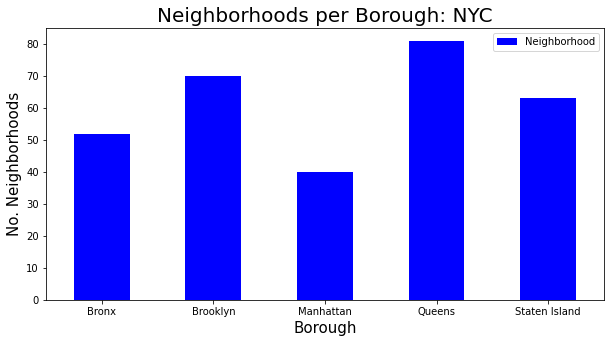

In [25]:

clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

### Use Case3: Study all Indian restaurants in all neighborhoods

In [30]:

column_names=['Borough', 'Neighborhood', 'ID','Name','Latitude','Longitude']# creating columns for the new dataframe indian_rest_myBorough
indian_rest_frame=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(ny_data),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    print(row)
    for resturant_detail in indian_restaurants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_frame = indian_rest_frame.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Latitude':Latitude,
                                                'Longitude':Longitude             
                                               }, ignore_index=True)
    count+=1    

( 1 / 306 ) Indian Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Indian Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Indian Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Indian Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Indian Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Indian Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Indian Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Indian Restaurants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Indian Restaurants in Norwood, Bronx:0
['Bronx', '

( 68 / 306 ) Indian Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Indian Restaurants in Gowanus, Brooklyn:1
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Indian Restaurants in Fort Greene, Brooklyn:1
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Indian Restaurants in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Indian Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Indian Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Indian Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Indian Restaurants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]


( 132 / 306 ) Indian Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Indian Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Indian Restaurants in Howard Beach, Queens:0
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Indian Restaurants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Indian Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Indian Restaurants in Kew Gardens, Queens:1
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Indian Restaurants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) Indian Restaurants in Flushing, Queens:0
['Queens', 'Flushing', 40.76445419697846, -73.83177300329582]
( 140 / 306 ) Indian Re

( 199 / 306 ) Indian Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Indian Restaurants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Indian Restaurants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Indian Restaurants in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Indian Restaurants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Indian Restaurants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Indian Restaurants in South Beach, Staten Island:0
['Staten Island', 'South Beach', 40.58024741350956, -74.0795529253982]
( 206 / 306 ) Indian Restaurants in Port Richmond, 

( 261 / 306 ) Indian Restaurants in New Lots, Brooklyn:0
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Indian Restaurants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Indian Restaurants in Mill Basin, Brooklyn:0
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Indian Restaurants in Jamaica Hills, Queens:2
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Indian Restaurants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Indian Restaurants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120040537]
( 267 / 306 ) Indian Restaurants in Astoria Heights, Queens:0
['Queens', 'Astoria Heights', 40.7703173929982, -73.89467996270574]
( 268 / 306 ) Indian Restaurants in Claremont Village, Bronx:0
['Bronx', 'Claremont Village', 40.83142834161548, -73.90119903387667]
( 

In [31]:
indian_rest_frame

,Borough,Neighborhood,ID,Name,Latitude,Longitude
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,40.898273,-73.867315
1,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,40.829774,-73.850535
2,Brooklyn,Bay Ridge,545835a1498e820edc6f636f,Bombay Grill,40.625801,-74.030621
3,Brooklyn,Greenpoint,51a5445c498ee0f182370cb2,Agra Taj Mahal,40.730201,-73.954241
4,Brooklyn,Bushwick,5169f5c4e4b0c7fcb77a0f3c,Agra Heights,40.698116,-73.925258
5,Brooklyn,Brooklyn Heights,4b8ffc16f964a520246e33e3,Curry Heights,40.695864,-73.993782
6,Brooklyn,Gowanus,52f18573498ec2c34e830ffd,Kanan's Indian Restaurant,40.673931,-73.994441
7,Brooklyn,Fort Greene,57596dad498e732300496b23,Dosa Royale,40.688527,-73.972906
8,Brooklyn,Clinton Hill,568d3902498e619efcbc3f58,Spice & Grill,40.693229,-73.967843
9,Brooklyn,Clinton Hill,4ace7c86f964a520d3d020e3,Kinara's,40.693229,-73.967843


In [69]:


ny_lat,ny_long=fetchGeoCoordinates('Manhattan,NY')

#print(ny_lat,ny_long)
ny_map = folium.Map(location=[ny_lat, ny_long], zoom_start=12)

# display the map of San Francisco
ny_map
#Now that we have the ny map do he superimposing from df
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(indian_rest_frame.Latitude, indian_rest_frame.Longitude):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
ny_map.add_child(incidents)
ny_map


Manhattan,NY
40.7896239 -73.9598939


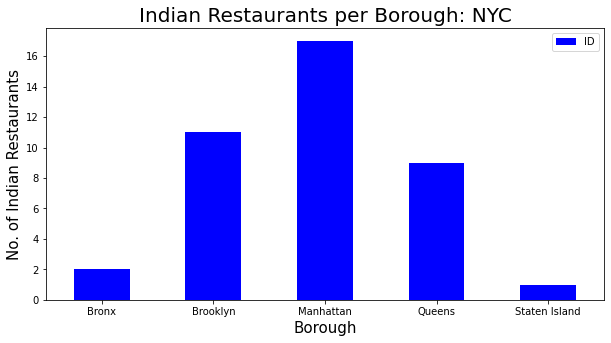

In [35]:
indian_rest_frame.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Indian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

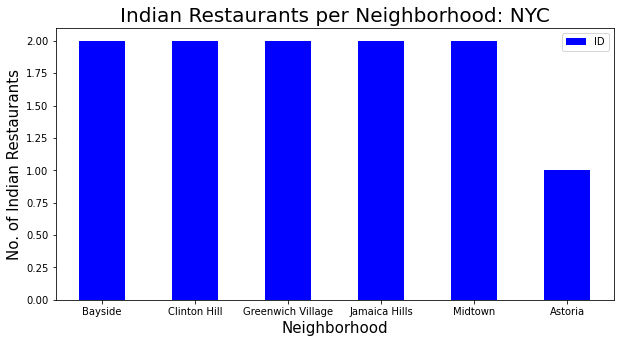

In [36]:
NOofNeigh = 6 # top number for graphing all the same past 6
indian_rest_frame.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Indian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

### Conclusion:
Looking at the above graphs, Staten Island has the least number of restaurants. So a new business owner can obviously pick this location for a start provided the demographics is favorable.
OR
A tourism company can get into an deal  with Manhattan borough restaurants with respect to its indian travellers 

### Use Case4 : Study a borough. I choose Manhattan

In [38]:
myBorough="Manhattan"
myBoroughData=ny_data[ny_data.Borough==myBorough]
myBoroughData.shape

(40, 4)

### Study the boroughs Indian restuarants

In [39]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Latitude','Longitude']# creating columns for the new dataframe indian_rest_myBorough
indian_rest_myBorough=pd.DataFrame(columns=column_names)
count=1
for row in myBoroughData.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(myBoroughData),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    print(row)
    for resturant_detail in indian_restaurants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_myBorough = indian_rest_myBorough.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Latitude':Latitude,
                                                'Longitude':Longitude             
                                               }, ignore_index=True)
    count+=1    

( 1 / 40 ) Indian Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 2 / 40 ) Indian Restaurants in Chinatown, Manhattan:0
['Manhattan', 'Chinatown', 40.71561842231432, -73.99427936255978]
( 3 / 40 ) Indian Restaurants in Washington Heights, Manhattan:1
['Manhattan', 'Washington Heights', 40.85190252555305, -73.93690027985234]
( 4 / 40 ) Indian Restaurants in Inwood, Manhattan:0
['Manhattan', 'Inwood', 40.86768396449915, -73.92121042203897]
( 5 / 40 ) Indian Restaurants in Hamilton Heights, Manhattan:1
['Manhattan', 'Hamilton Heights', 40.823604284811935, -73.94968791883366]
( 6 / 40 ) Indian Restaurants in Manhattanville, Manhattan:1
['Manhattan', 'Manhattanville', 40.8169344294978, -73.9573853935188]
( 7 / 40 ) Indian Restaurants in Central Harlem, Manhattan:0
['Manhattan', 'Central Harlem', 40.81597606742414, -73.94321112603905]
( 8 / 40 ) Indian Restaurants in East Harlem, Manhattan:0
['Manhattan', 'East Harlem', 40.7922494

In [40]:
indian_rest_myBorough.shape

(17, 6)

In [41]:
indian_rest_myBorough.to_csv('indianrest_borough_tocsv1.csv')

In [42]:

indian_df = pd.read_csv('indianrest_borough_tocsv1.csv')
indian_df

,Unnamed: 0,Borough,Neighborhood,ID,Name,Latitude,Longitude
0,0,Manhattan,Washington Heights,4ae7876ef964a5201eac21e3,Kismat Indian Restaurant,40.851903,-73.936900
1,1,Manhattan,Hamilton Heights,54c2bd96498eaf5142e3fe92,Clove Indian Restaurant & Bar,40.823604,-73.949688
2,2,Manhattan,Manhattanville,529d382a11d2dd5ef107e641,Chapati House - NYC,40.816934,-73.957385
3,3,Manhattan,Upper West Side,4b0dec08f964a520ae5223e3,Alachi Masala,40.787658,-73.977059
4,4,Manhattan,Midtown,49d91c12f964a520015e1fe3,The Kati Roll Company,40.754691,-73.981669
5,5,Manhattan,Midtown,5953e40462420b044e8989f4,indikitch,40.754691,-73.981669
6,6,Manhattan,Greenwich Village,56c931b2cd10407d3ecbefda,Ananda,40.726933,-73.999914
7,7,Manhattan,Greenwich Village,4593ed04f964a52050401fe3,The Kati Roll Company,40.726933,-73.999914
8,8,Manhattan,Tribeca,4bbb9dbded7776b0e1ad3e51,Tamarind TriBeCa,40.721522,-74.010683
9,9,Manhattan,West Village,5803c0db38fa71491b748a7d,Taco Mahal,40.734434,-74.006180


In [43]:
#Draw folium map
studyBorough=myBorough+',NY'
print(studyBorough)
boroLat,boroLong=fetchGeoCoordinates(studyBorough)
print(boroLat,boroLong)

Manhattan,NY
Manhattan,NY
40.7896239 -73.9598939
40.7896239 -73.9598939


In [44]:
venues_map=draw_folium(boroLat,boroLong,13,indian_df)

In [45]:
venues_map

###  UseCase 5: Exploring a particular restaurant: Allow the user to enter venue ID 

In [46]:
venue_id = '4ae7876ef964a5201eac21e3' # ID of Kismat Indian Restaurant
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
url

'https://api.foursquare.com/v2/venues/4ae7876ef964a5201eac21e3?client_id=VTCFGDWGL3HENURPZ3FTCJCJQSV4XIPVC5B4EFXCVMPGX5OI&client_secret=YXSVGIAT2R04AVLO3B1CAN2K5ZTOVKU4GIUKNRUYYESUHXSG&oauth_token=MHRHM0F5EBKHKDRPEYBCYNQNCFUTEA0XMJKNDSMXZULVNET4&v=20180604'

In [47]:
result = requests.get(url).json()
result


{'meta': {'code': 200, 'requestId': '5ff143b0bec16445af455bbb'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venue': {'id': '4ae7876ef964a5201eac21e3',
   'name': 'Kismat Indian Restaurant',
   'contact': {'phone': '2127958633',
    'formattedPhone': '(212) 795-8633',
    'twitter': 'kismatindian'},
   'location': {'address': '603 Fort Washington Ave',
    'crossStreet': '187th St',
    'lat': 40.855221723964846,
    'lng': -73.93696683600031,
    'labeledLatLngs': [{'label': 'display',
      'lat': 40.855221723964846,
      'lng': -73.93696683600031}],
    'postalCode': '10040',
    'cc': 'US',
    'city': 'New York',
    'state': 'NY',
    'country': 'United States',
    'formattedAddress': ['603 Fort Washington Ave (187th St)',
     'New York, NY 10040']},
   'canonicalUrl': 'https://foursquare.com/v/kismat-indian-restaurant/4ae7876ef964a5201eac21e3',
   'categories': [{'id': '4bf58dd8d48988d10f941735',
     'name': 'Indian Restaurant

In [48]:
#Obtain teh rating of the above venue
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

7.9


In [49]:
venue_df=get_venue_details('4ae7876ef964a5201eac21e3')
venue_df

{'meta': {'code': 200, 'requestId': '5ff143b62b881e51cd5366cf'}, 'response': {'venue': {'id': '4ae7876ef964a5201eac21e3', 'name': 'Kismat Indian Restaurant', 'contact': {'phone': '2127958633', 'formattedPhone': '(212) 795-8633', 'twitter': 'kismatindian'}, 'location': {'address': '603 Fort Washington Ave', 'crossStreet': '187th St', 'lat': 40.855221723964846, 'lng': -73.93696683600031, 'labeledLatLngs': [{'label': 'display', 'lat': 40.855221723964846, 'lng': -73.93696683600031}], 'postalCode': '10040', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['603 Fort Washington Ave (187th St)', 'New York, NY 10040', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kismat-indian-restaurant/4ae7876ef964a5201eac21e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '

,ID,Name,Likes,Rating,Tips
0,4ae7876ef964a5201eac21e3,Kismat Indian Restaurant,46,7.9,25


In [56]:
indian_rest_frame.columns

Index(['Borough', 'Neighborhood', 'ID', 'Name', 'Latitude', 'Longitude'], dtype='object')

### UseCase 6: Get likes,ratings and tips of the various Indian restaurants and do a comparison

In [57]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_details=pd.DataFrame(columns=column_names)
count=1
for row in indian_rest_frame.values.tolist():
    Borough,Neighborhood,ID,Name,Latitude,Longitude=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_frame),')','processed')
    indian_rest_stats_details = indian_rest_stats_details.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1


{'meta': {'code': 200, 'requestId': '5ff147e88549cf75f736329a'}, 'response': {'venue': {'id': '4c0448d9310fc9b6bf1dc761', 'name': 'Curry Spot', 'contact': {'phone': '7187085900', 'formattedPhone': '(718) 708-5900'}, 'location': {'address': '4268 Katonah Ave', 'crossStreet': 'E 235 Street', 'lat': 40.897624941880906, 'lng': -73.86714729157393, 'labeledLatLngs': [{'label': 'display', 'lat': 40.897624941880906, 'lng': -73.86714729157393}, {'label': 'entrance', 'lat': 40.897709, 'lng': -73.86707}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4268 Katonah Ave (E 235 Street)', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-spot/4c0448d9310fc9b6bf1dc761', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 

{'meta': {'code': 200, 'requestId': '5ff147e84536486d2a6b1f46'}, 'response': {'venue': {'id': '545835a1498e820edc6f636f', 'name': 'Bombay Grill', 'contact': {'phone': '7184912500', 'formattedPhone': '(718) 491-2500'}, 'location': {'address': '8716 3rd Ave', 'lat': 40.622371, 'lng': -74.03179899999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.622371, 'lng': -74.03179899999999}, {'label': 'entrance', 'lat': 40.622344, 'lng': -74.031673}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8716 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bombay-grill/545835a1498e820edc6f636f', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4

{'meta': {'code': 200, 'requestId': '5ff147e93577fa053cdee1a0'}, 'response': {'venue': {'id': '5169f5c4e4b0c7fcb77a0f3c', 'name': 'Agra Heights', 'contact': {'phone': '7184435700', 'formattedPhone': '(718) 443-5700'}, 'location': {'address': '226 Wilson Ave', 'crossStreet': 'btwn Harman & Himrod St', 'lat': 40.698094445626104, 'lng': -73.92135507234042, 'labeledLatLngs': [{'label': 'display', 'lat': 40.698094445626104, 'lng': -73.92135507234042}, {'label': 'entrance', 'lat': 40.698115, 'lng': -73.921387}], 'postalCode': '11237', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['226 Wilson Ave (btwn Harman & Himrod St)', 'Brooklyn, NY 11237', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/agra-heights/5169f5c4e4b0c7fcb77a0f3c', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/

{'meta': {'code': 200, 'requestId': '5ff147e9b4359f7d96fe434f'}, 'response': {'venue': {'id': '52f18573498ec2c34e830ffd', 'name': "Kanan's Indian Restaurant", 'contact': {'phone': '7183693777', 'formattedPhone': '(718) 369-3777'}, 'location': {'address': '452 3rd Ave', 'crossStreet': '9th Street', 'lat': 40.671890999999995, 'lng': -73.99094000000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.671890999999995, 'lng': -73.99094000000001}, {'label': 'entrance', 'lat': 40.671842, 'lng': -73.990867}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['452 3rd Ave (9th Street)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kanans-indian-restaurant/52f18573498ec2c34e830ffd', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_

{'meta': {'code': 200, 'requestId': '5ff147e95c9afa7d854e13e7'}, 'response': {'venue': {'id': '57596dad498e732300496b23', 'name': 'Dosa Royale', 'contact': {'phone': '7185763800', 'formattedPhone': '(718) 576-3800'}, 'location': {'address': '258 Dekalb Ave', 'lat': 40.689466368706604, 'lng': -73.96870434089776, 'labeledLatLngs': [{'label': 'display', 'lat': 40.689466368706604, 'lng': -73.96870434089776}], 'postalCode': '11205', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['258 Dekalb Ave', 'New York, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dosa-royale/57596dad498e732300496b23', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 24}, 'url': 'http://www.dosaroyale.com', 

{'meta': {'code': 200, 'requestId': '5ff147ea8549cf75f736359c'}, 'response': {'venue': {'id': '4ace7c86f964a520d3d020e3', 'name': "Kinara's", 'contact': {'phone': '7182374008', 'formattedPhone': '(718) 237-4008'}, 'location': {'address': '368 Myrtle Ave', 'crossStreet': 'Adelphi Street', 'lat': 40.69322031901606, 'lng': -73.97142314141769, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69322031901606, 'lng': -73.97142314141769}, {'label': 'entrance', 'lat': 40.693105, 'lng': -73.971458}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['368 Myrtle Ave (Adelphi Street)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kinaras/4ace7c86f964a520d3d020e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 

{'meta': {'code': 200, 'requestId': '5ff147ea191f5d2376cce5c1'}, 'response': {'venue': {'id': '4bb93b70cf2fc9b6fe64a002', 'name': 'Gandhi Fine Indian Cuisine', 'contact': {'phone': '7182827012', 'formattedPhone': '(718) 282-7012'}, 'location': {'address': '2032 Bedford Ave', 'crossStreet': 'btwn Clarkson Ave & Parkside Ave', 'lat': 40.65516762218564, 'lng': -73.95632450081226, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65516762218564, 'lng': -73.95632450081226}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2032 Bedford Ave (btwn Clarkson Ave & Parkside Ave)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gandhi-fine-indian-cuisine/4bb93b70cf2fc9b6fe64a002', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 's

{'meta': {'code': 200, 'requestId': '5ff147ea960a06004f72d890'}, 'response': {'venue': {'id': '4ae7876ef964a5201eac21e3', 'name': 'Kismat Indian Restaurant', 'contact': {'phone': '2127958633', 'formattedPhone': '(212) 795-8633', 'twitter': 'kismatindian'}, 'location': {'address': '603 Fort Washington Ave', 'crossStreet': '187th St', 'lat': 40.855221723964846, 'lng': -73.93696683600031, 'labeledLatLngs': [{'label': 'display', 'lat': 40.855221723964846, 'lng': -73.93696683600031}], 'postalCode': '10040', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['603 Fort Washington Ave (187th St)', 'New York, NY 10040', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kismat-indian-restaurant/4ae7876ef964a5201eac21e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '

{'meta': {'code': 200, 'requestId': '5ff147eb91aecb7c6e39f85f'}, 'response': {'venue': {'id': '529d382a11d2dd5ef107e641', 'name': 'Chapati House - NYC', 'contact': {'phone': '2127497200', 'formattedPhone': '(212) 749-7200', 'twitter': 'chapatihousenyc'}, 'location': {'address': '3153 Broadway', 'crossStreet': 'Tiemann Pl.', 'lat': 40.81457249971737, 'lng': -73.95915381671377, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81457249971737, 'lng': -73.95915381671377}], 'postalCode': '10027', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3153 Broadway (Tiemann Pl.)', 'New York, NY 10027', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chapati-house--nyc/529d382a11d2dd5ef107e641', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}

{'meta': {'code': 200, 'requestId': '5ff147eb823a4a5812c98935'}, 'response': {'venue': {'id': '49d91c12f964a520015e1fe3', 'name': 'The Kati Roll Company', 'contact': {'phone': '2127304280', 'formattedPhone': '(212) 730-4280', 'twitter': 'katirollcompany'}, 'location': {'address': '49 W 39th St', 'crossStreet': 'btwn 5th & 6th Ave', 'lat': 40.75265571457166, 'lng': -73.98477837472183, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75265571457166, 'lng': -73.98477837472183}], 'postalCode': '10018', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['49 W 39th St (btwn 5th & 6th Ave)', 'New York, NY 10018', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-kati-roll-company/49d91c12f964a520015e1fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '5ff147eb6a34a60d6594cd68'}, 'response': {'venue': {'id': '56c931b2cd10407d3ecbefda', 'name': 'Ananda', 'contact': {}, 'location': {'address': '210 Thompson St', 'crossStreet': 'btwn W 3rd & Bleecker Sts', 'lat': 40.72883889496238, 'lng': -73.9993364782382, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72883889496238, 'lng': -73.9993364782382}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['210 Thompson St (btwn W 3rd & Bleecker Sts)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ananda/56c931b2cd10407d3ecbefda', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 20}, 'url': 'http://www.ahimsa.nyc', '

{'meta': {'code': 200, 'requestId': '5ff147ecd358eb7aca3affe9'}, 'response': {'venue': {'id': '4593ed04f964a52050401fe3', 'name': 'The Kati Roll Company', 'contact': {'phone': '2124206517', 'formattedPhone': '(212) 420-6517'}, 'location': {'address': '99 Macdougal St', 'crossStreet': 'btwn Bleecker & W 3rd St', 'lat': 40.7295697222648, 'lng': -74.00086061309852, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7295697222648, 'lng': -74.00086061309852}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['99 Macdougal St (btwn Bleecker & W 3rd St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-kati-roll-company/4593ed04f964a52050401fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': Tr

{'meta': {'code': 200, 'requestId': '5ff147eddc429f5febc780d5'}, 'response': {'venue': {'id': '5803c0db38fa71491b748a7d', 'name': 'Taco Mahal', 'contact': {'phone': '6467191553', 'formattedPhone': '(646) 719-1553', 'instagram': 'tacomahalnyc', 'facebook': '575545749278543', 'facebookUsername': 'TacoMahalnyc', 'facebookName': 'Taco Mahal'}, 'location': {'address': '73 7th Ave S', 'lat': 40.73240508476288, 'lng': -74.00350113625272, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73240508476288, 'lng': -74.00350113625272}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['73 7th Ave S', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taco-mahal/5803c0db38fa71491b748a7d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 's

{'meta': {'code': 200, 'requestId': '5ff147ed4536486d2a6b287e'}, 'response': {'venue': {'id': '5b770657c0cacb002c89bc63', 'name': 'The Kati Roll Company', 'contact': {}, 'location': {'address': '22 Maiden Ln', 'lat': 40.70911435070483, 'lng': -74.0090911929708, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70911435070483, 'lng': -74.0090911929708}], 'postalCode': '10038', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['22 Maiden Ln', 'New York, NY 10038', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-kati-roll-company/5b770657c0cacb002c89bc63', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 2

{'meta': {'code': 200, 'requestId': '5ff147ed1fbc1169c9df269b'}, 'response': {'venue': {'id': '5782c9ce498edde587f5aa14', 'name': 'Tikka Indian Grill', 'contact': {'phone': '7184801307', 'formattedPhone': '(718) 480-1307'}, 'location': {'address': '119-30 Metropolitan Ave', 'lat': 40.70587364181698, 'lng': -73.83094233462995, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70587364181698, 'lng': -73.83094233462995}], 'postalCode': '11415', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['119-30 Metropolitan Ave', 'Queens, NY 11415', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tikka-indian-grill/5782c9ce498edde587f5aa14', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 2}, 'url': 'http

{'meta': {'code': 200, 'requestId': '5ff147eed358eb7aca3b0279'}, 'response': {'venue': {'id': '58855a59af7d1717fffdf996', 'name': 'Fresh Pond Spice', 'contact': {'phone': '7184175100', 'formattedPhone': '(718) 417-5100'}, 'location': {'address': '6402 Fresh Pond Rd', 'lat': 40.71014, 'lng': -73.899582, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71014, 'lng': -73.899582}], 'postalCode': '11385', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['6402 Fresh Pond Rd', 'Queens, NY 11385', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fresh-pond-spice/58855a59af7d1717fffdf996', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'

{'meta': {'code': 200, 'requestId': '5ff147f09d461e6e743b496d'}, 'response': {'venue': {'id': '4be74a502468c928505a0243', 'name': 'Taste Of India II', 'contact': {'phone': '7189874700', 'formattedPhone': '(718) 987-4700'}, 'location': {'address': '287 New Dorp Ln', 'lat': 40.57212651619049, 'lng': -74.11267401240129, 'labeledLatLngs': [{'label': 'display', 'lat': 40.57212651619049, 'lng': -74.11267401240129}], 'postalCode': '10306', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['287 New Dorp Ln', 'Staten Island, NY 10306', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taste-of-india-ii/4be74a502468c928505a0243', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant'

{'meta': {'code': 200, 'requestId': '5ff147f0d358eb7aca3b06f9'}, 'response': {'venue': {'id': '5a1e961c1987ec47beed877d', 'name': 'Baar Baar', 'contact': {'phone': '2122281200', 'formattedPhone': '(212) 228-1200', 'twitter': 'baarbaarnyc', 'instagram': 'baarbaarnyc', 'facebook': '478023699251632', 'facebookUsername': 'baarbaarnyc', 'facebookName': 'Baar Baar'}, 'location': {'address': '13 E 1st St', 'crossStreet': 'btw Bowery & 2nd Ave', 'lat': 40.724533801523286, 'lng': -73.99162419418478, 'labeledLatLngs': [{'label': 'display', 'lat': 40.724533801523286, 'lng': -73.99162419418478}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['13 E 1st St (btw Bowery & 2nd Ave)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/baar-baar/5a1e961c1987ec47beed877d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'In

{'meta': {'code': 200, 'requestId': '5ff147f130b6ce4dff6212ef'}, 'response': {'venue': {'id': '4c434b2bd691c9b6ef8f8f0a', 'name': 'Sagar Restaurant', 'contact': {'phone': '7182985696', 'formattedPhone': '(718) 298-5696'}, 'location': {'address': '168-25 B Hillside Ave', 'lat': 40.710328623498505, 'lng': -73.79412262466633, 'labeledLatLngs': [{'label': 'display', 'lat': 40.710328623498505, 'lng': -73.79412262466633}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168-25 B Hillside Ave', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sagar-restaurant/4c434b2bd691c9b6ef8f8f0a', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'url': 'http://

{'meta': {'code': 200, 'requestId': '5ff147f1dc429f5febc7886a'}, 'response': {'venue': {'id': '4fe4fb50c2eee335e4fea69d', 'name': 'Moti Mahal Delux', 'contact': {'phone': '2123713535', 'formattedPhone': '(212) 371-3535', 'twitter': 'motimahalus', 'facebook': '464790890213866', 'facebookUsername': 'MotiMahalDeluxNYC', 'facebookName': 'Moti Mahal Delux, NYC'}, 'location': {'address': '1149 1st Ave', 'crossStreet': '63rd Street', 'lat': 40.76209761945207, 'lng': -73.96028513480461, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76209761945207, 'lng': -73.96028513480461}, {'label': 'entrance', 'lat': 40.762073, 'lng': -73.960379}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1149 1st Ave (63rd Street)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/moti-mahal-delux/4fe4fb50c2eee335e4fea69d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'plura

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
35,Manhattan,Civic Center,50b02338e4b047828b2277c1,Benares,97,7.4,44
36,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant,10,6.6,6
37,Queens,Jamaica Hills,0,0,0,0.0,0
38,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux,186,8.1,83
39,Manhattan,Flatiron,52a1fa08498ede15b1530912,Deep Indian Kitchen,681,8.3,132


In [63]:
indian_rest_stats_details
  

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.7,10
1,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Brooklyn,Bay Ridge,545835a1498e820edc6f636f,Bombay Grill,14,7.1,4
3,Brooklyn,Greenpoint,51a5445c498ee0f182370cb2,Agra Taj Mahal,35,6.9,18
4,Brooklyn,Bushwick,5169f5c4e4b0c7fcb77a0f3c,Agra Heights,12,5.8,5
5,Brooklyn,Brooklyn Heights,4b8ffc16f964a520246e33e3,Curry Heights,31,7.2,17
6,Brooklyn,Gowanus,52f18573498ec2c34e830ffd,Kanan's Indian Restaurant,24,7.7,8
7,Brooklyn,Fort Greene,57596dad498e732300496b23,Dosa Royale,78,8.5,24
8,Brooklyn,Clinton Hill,568d3902498e619efcbc3f58,Spice & Grill,21,7.7,6
9,Brooklyn,Clinton Hill,4ace7c86f964a520d3d020e3,Kinara's,9,5.6,20


In [64]:

indian_rest_stats_details.sort_values(by='Likes', ascending=False)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
17,Manhattan,Midtown,49d91c12f964a520015e1fe3,The Kati Roll Company,831,8.6,255
39,Manhattan,Flatiron,52a1fa08498ede15b1530912,Deep Indian Kitchen,681,8.3,132
21,Manhattan,Tribeca,4bbb9dbded7776b0e1ad3e51,Tamarind TriBeCa,600,9.0,150
20,Manhattan,Greenwich Village,4593ed04f964a52050401fe3,The Kati Roll Company,472,8.7,140
38,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux,186,8.1,83
34,Manhattan,Noho,5a1e961c1987ec47beed877d,Baar Baar,159,8.8,36
22,Manhattan,West Village,5803c0db38fa71491b748a7d,Taco Mahal,122,8.6,27
35,Manhattan,Civic Center,50b02338e4b047828b2277c1,Benares,97,7.4,44
12,Brooklyn,North Side,5631511b498e3d6d7e0a4df0,Tikka Indian Grill,95,8.5,29
11,Brooklyn,Prospect Lefferts Gardens,4bb93b70cf2fc9b6fe64a002,Gandhi Fine Indian Cuisine,83,8.6,49


### The Kati Roll Company in Manhattan has the maximum number of likes 

In [65]:
indian_rest_stats_details.sort_values(by='Rating', ascending=False)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
21,Manhattan,Tribeca,4bbb9dbded7776b0e1ad3e51,Tamarind TriBeCa,600,9.0,150
34,Manhattan,Noho,5a1e961c1987ec47beed877d,Baar Baar,159,8.8,36
20,Manhattan,Greenwich Village,4593ed04f964a52050401fe3,The Kati Roll Company,472,8.7,140
11,Brooklyn,Prospect Lefferts Gardens,4bb93b70cf2fc9b6fe64a002,Gandhi Fine Indian Cuisine,83,8.6,49
22,Manhattan,West Village,5803c0db38fa71491b748a7d,Taco Mahal,122,8.6,27
17,Manhattan,Midtown,49d91c12f964a520015e1fe3,The Kati Roll Company,831,8.6,255
7,Brooklyn,Fort Greene,57596dad498e732300496b23,Dosa Royale,78,8.5,24
12,Brooklyn,North Side,5631511b498e3d6d7e0a4df0,Tikka Indian Grill,95,8.5,29
19,Manhattan,Greenwich Village,56c931b2cd10407d3ecbefda,Ananda,81,8.4,20
18,Manhattan,Midtown,5953e40462420b044e8989f4,indikitch,62,8.3,3


### Tamarind TriBeCa in Manhattan has the maximum ratings of 9.0

### Conclusions
Manhattan has the least number of neighborhoods but the most number of Indian restaurants. So its ideal place for Indian food lovers and Indian tourists 
Staten Island has the least number of Indian restaurants. So can be a good choice to start off. Of course there are other factors like demographics etc 
Tamarind TriBeCa in Manhattan has the maximum ratings of 9.0
The Kati Roll Company in Manhattan has the maximum number of likes